In [19]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch
from data_utils.MoleculeDataSet import PointCloudMoleculeDataSet, load_and_align_QM7


In [2]:
FP = '/home/meliao/projects/Pointnet_Pointnet2_pytorch/log/regression_QM7/2022-11-23_14-13/epoch_results.txt'

In [3]:
df = pd.read_table(FP)

In [4]:
df.head()

,epoch,n_test,n_train,n_val,test_MSE,train_MSE,val_MSE
0,0,1433,5159,573,55681.703125,752226.500000,47907.425781
1,1,1433,5159,573,48866.183594,64809.320312,41113.136719
2,2,1433,5159,573,51642.156250,62656.679688,43947.078125
3,3,1433,5159,573,53554.117188,61239.738281,45619.945312
4,4,1433,5159,573,52255.488281,60830.539062,43371.246094


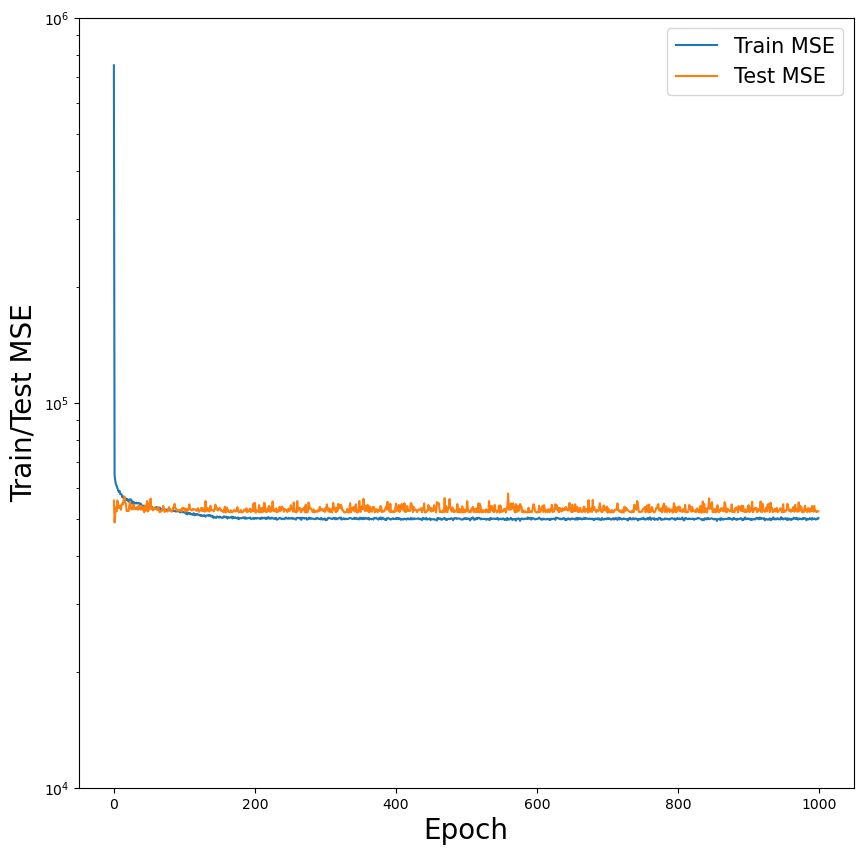

In [7]:
fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
fig.set_size_inches(10, 10)

ax.plot(df['epoch'], df['train_MSE'], '-', label='Train MSE')
ax.plot(df['epoch'], df['test_MSE'], '-', label='Test MSE')

ax.set_yscale('log')
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Train/Test MSE', size=20)
ax.set_ylim(1e04, 1e06)


ax.legend(prop={'size': 15})
plt.show()

# Load data and best-performing model

NOTE: This does not accurately reflect the train/val/test split used in training.

In [16]:
DATA_FP = '/home/meliao/projects/invariant-random-features-code/data/qm7/qm7.mat'
N_TRAIN = 5732
N_TEST = 1433

train_dset, val_dset, test_dset = load_and_align_QM7(fp=DATA_FP,
                                                        n_train=N_TRAIN,
                                                        n_test=N_TEST,
                                                        validation_set_fraction=0.1)
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
ROOT_DIR = '/home/meliao/projects/Pointnet_Pointnet2_pytorch/'
sys.path.append(os.path.join(ROOT_DIR, 'models'))
model = importlib.import_module('pointnet2_reg_msg')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = model.get_model(n_centroids_1=10,
                                    msg_radii_1=[2., 4., 8.],
                                    msg_nsample_1=[4, 8, 16],
                                    n_centroids_2=4,
                                    msg_radii_2=[2., 4., 8.],
                                    msg_nsample_2=[2, 4, 8],
                                    in_channels=5,
                                    out_channels=128,
                                    device=device)

In [24]:
EXP_DIR = '/home/meliao/projects/Pointnet_Pointnet2_pytorch/log/regression_QM7/2022-11-23_14-13/'
checkpoint = torch.load(str(EXP_DIR) + '/checkpoints/best_model.pth')
classifier.load_state_dict(checkpoint['model_state_dict'])

classifier = classifier.to(device)

# Run prediction

In [28]:
classifier = classifier.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for points_and_features, U_matrices, target in train_loader:
        points_and_features = points_and_features.to(device)
        U_matrices = U_matrices.to(device)
        
        preds = classifier(points_and_features, U_matrices)
        
        all_preds.append(preds.cpu())
        all_labels.append(target)

In [29]:
all_preds = torch.cat(all_preds).flatten().numpy()

In [30]:
all_labels = torch.cat(all_labels).flatten().numpy()

# Plot preds and actuals

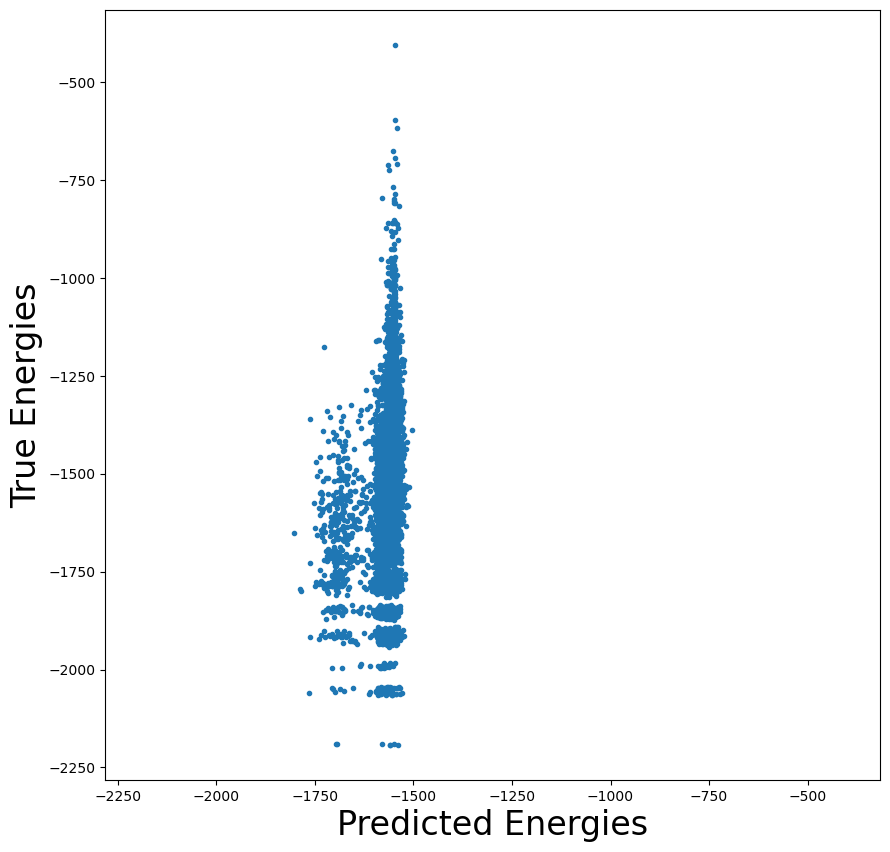

In [37]:
fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
fig.set_size_inches(10, 10)

ax.plot(all_preds, all_labels, '.')
# ax.plot(ax.get_ybound(), ax.get_ybound(), '--')
ax.set_xlabel('Predicted Energies', size=24)
ax.set_ylabel('True Energies', size=24)
ax.set_xbound(*ax.get_ybound())
plt.show()